In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import json
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
%matplotlib inline

#################################
# Settings to configure

drop = 1
dpi = 200
resolution = '2y'
virus = 'h3n2'
segment = 'ha'

# input_file_prefix = '../blab/nextflu/auspice/data/flu_' + virus + '_' + segment + '_' + resolution
input_file_prefix = '../nextstrain/auspice/data/flu_seasonal_' + virus + '_' + segment + '_' + resolution
output_file_prefix = 'figures/'

In [2]:
mutation_labels = {}
clades = ['A2', "A2/re"]
# Base clades
# Clade 3c2.a1. 171K, characteristic: nuc:234G
# Clade 3c3.a. 159S, characteristic: nuc:636A
# Subclades
# Clade 1 / A4. 31S, 53N, 144R, 171K, 192T, 197H, characteristic: 197H
# Clade 2 / A3. 121K, 144K, characteristic: nuc:1320T
# Clade 3 / A2. 131K, 142K, 261Q, characteristic: 131K
# Clade 4 / A1a. 142R, HA2:150E, characteristic: HA2:150E ---> additional 135K
# Clade 5 / A1b. 92R, 311Q, characteristic: nuc:538C ---> additional 135K
mutation_labels = {
    'nuc:234G': '3c2.A1',
    'nuc:636A': '3c3.A',
    'HA1:197H': "A4",
    'nuc:1320T': "A3",
    'nuc:1461T': "A3/135K",
    'HA1:131K': "A2",
    'nuc:1689T': "A2/re",
    'HA2:150E': "A1a",
    'nuc:538C': "A1b",
    'nuc:453T': "A1b/135N",
    'nuc:233G': "A1b/135K",
    'na:386S': "A2/re-NA"
}
# mutations = ['nuc:636A', 'nuc:234G'] # base clades
# mutations = ['nuc:636A', 'HA2:150E', 'nuc:538C', 'HA1:131K', 'nuc:1320T', 'HA1:197H'] # major clades
# mutations = ['nuc:453T', 'nuc:233G', 'nuc:1689T'] # recently emerged clades
# mutations = ['nuc:636A', 'HA2:150E', 'nuc:538C'] # 3c3A, A1a, A1b
# mutations = ['HA1:131K', 'nuc:1320T', 'HA1:197H'] # A2, A3, A4
mutations = ['nuc:1689T', 'HA1:131K'] # Just RE and A2
clade_legend = {'panel':0, 'loc':3}
mut_legend = {'panel':0, 'loc':3}
ymax = 800

Plotting dataset h3n2/2y
Plotting sample counts


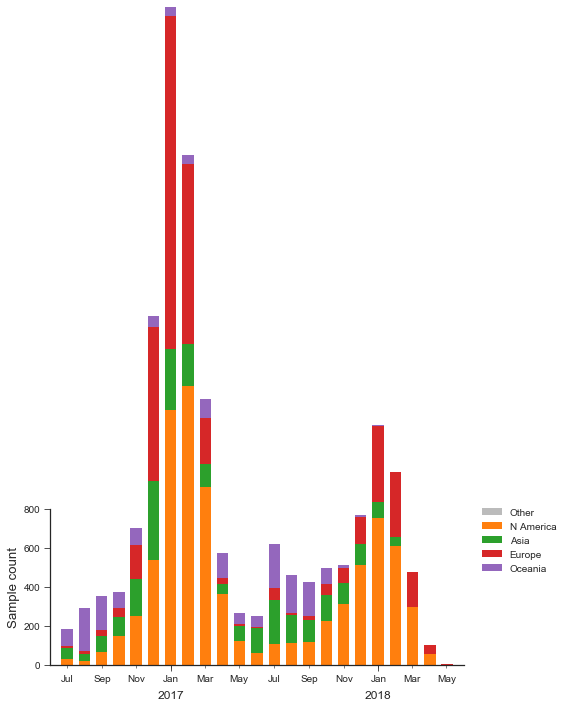

In [3]:
# Plotting

print "Plotting dataset " + virus + "/" + resolution

freqs = json.load(open(input_file_prefix+'_frequencies.json'))
counts = freqs['counts']
offset = datetime(2000,1,1).toordinal()
pivots = [offset+(x-2000)*365.25 for x in freqs['pivots']]
meta = json.load(open(input_file_prefix+'_meta.json'))
region_names = meta['geo']['region'].keys()
region_codes = {'EU':['europe'], 'EUAS':['china', 'south_asia', 'japan_korea','southeast_asia'],
                'NA':["north_america"], 'OC':["oceania"]}

offset = datetime(2000,1,1).toordinal()
regions = ['NA', 'AS', 'EU', 'OC', 'global']
#regions = ['global']
region_label = {'NA': 'N America', 'AS': 'Asia', 'EU': 'Europe', 'OC': 'Oceania', 'global': 'Global'}
cols = sns.color_palette(n_colors=len(regions))
cols.pop(0)
cols.append(sns.color_palette(["#3E547F"], n_colors=1)[0])
fs=12

years = YearLocator()
months = MonthLocator(range(1, 13), bymonthday=1, interval=2)
yearsFmt = DateFormatter('%Y')
monthsFmt = DateFormatter("%b")

sns.set_style('ticks')
plt.ion()
show_errorbars = True

n=2
n_std_dev=2
l = len(pivots)
bins = np.array([c[0] for c in counts])[-l:]
date_bins = []
date_bins=pivots
count_array = np.array([counts[c] for c in counts])[-l:,:].T
count_by_region = {region: sum(x) for region,x in counts.iteritems() if region!='global'}
smoothed_count_array = np.array([np.convolve(np.ones(n, dtype=float)/n, c, mode='same')
                        for c in count_array])
smoothed_count_by_region = {region: np.convolve(np.ones(n, dtype=float)/n, c, mode='same')
                            for region, c in counts.iteritems()}

smoothed_count_by_region.update({r1:smoothed_count_by_region[r2] for r1,r2 in
                            [['north_america', 'NA'], ['europe', 'EU'], ['asia', 'AS'], ['oceania', 'OC']]})

print "Plotting sample counts"
fig, ax = plt.subplots(figsize=(8, 3))
tmpcounts = np.zeros(len(date_bins[drop:]))
plt.bar(date_bins[drop:], counts['global'][drop:], width=20, linewidth=0, label="Other", color="#bbbbbb", clip_on=False)
for c,region in zip(cols, regions):
    if region!='global':
        plt.bar(date_bins[drop:], counts[region][drop:], bottom=tmpcounts, width=20, linewidth=0,
                label=region_label[region], color=c, clip_on=False)
        tmpcounts += np.array(counts[region][drop:])
ax.set_xlim([pivots[drop-1], pivots[-1]])
ax.set_ylim(0,ymax)
ax.tick_params(axis='x', which='major', labelsize=fs, pad=20)
ax.tick_params(axis='x', which='minor', pad=7)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.set_ylabel('Sample count', fontsize=fs*1.1)
ax.legend(loc=3, ncol=1, bbox_to_anchor=(1.02, 0.53))
plt.subplots_adjust(left=0.1, right=0.82, top=0.94, bottom=0.22)
sns.despine()
plt.savefig('{}{}_counts.png'.format(output_file_prefix,virus), dpi=dpi)

Plotting clade frequencies


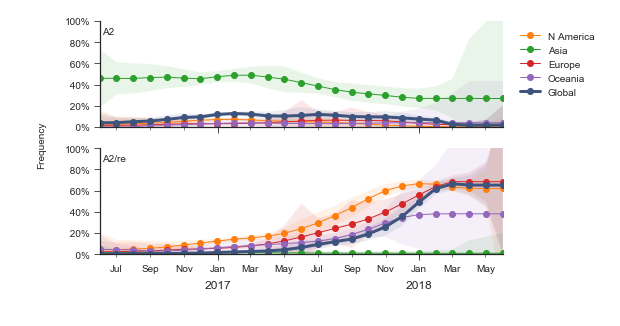

In [4]:
if len(clades):
    print "Plotting clade frequencies"
    fig, axs = plt.subplots(len(clades), 1, sharex=True, figsize=(8, len(clades)*2))
    for clade, ax in zip(clades, axs):
        for c,(region, r1) in zip(cols, [('north_america', 'NA'), ('china', 'AS'), ('europe','EU'), ('oceania','OC'), ('global', 'global')]):
            try:
                tmp_freq = np.array(freqs['%s_%s'%(region, clade)])
                if clade=='3c2.a':
                    tmp_freq -= np.array(freqs['%s_%s'%(region, '3c2.a1')])
                elif clade=='A2':
                    tmp_freq -= np.array(freqs['%s_%s'%(region, 'A2/re')])
                if tmp_freq is not None:
                    std_dev = np.sqrt(tmp_freq*(1-tmp_freq)/(smoothed_count_by_region[r1]+1))
                    ax.plot(pivots, tmp_freq,'-o', label = region_label[r1], c=c, lw=3 if region=='global' else 1)
                    if show_errorbars:
                        ax.fill_between(pivots, tmp_freq-n_std_dev*std_dev, tmp_freq+n_std_dev*std_dev, facecolor=c, linewidth=0, alpha=0.1)
            except:
                print "skipping", clade, region
        ax.set_xlim([pivots[0], pivots[-1]])
        ax.set_ylim(0,1)
        ax.text(pivots[0]+5, 0.88, clade)
        ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
        ax.tick_params(axis='x', which='major', labelsize=fs, pad=20)
        ax.tick_params(axis='x', which='minor', pad=7)
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.xaxis.set_minor_locator(months)
        ax.xaxis.set_minor_formatter(monthsFmt)
    fig.autofmt_xdate(bottom=0.25, rotation=0, ha='center')
    fax = fig.add_axes( [0., 0., 1, 1] )
    fax.set_axis_off()
    fax.set_xlim(0, 1)
    fax.set_ylim(0, 1)
    fax.text(0.02, 0.54, "Frequency", rotation='vertical', horizontalalignment='center', verticalalignment='center')
    axs[clade_legend['panel']].legend(loc=clade_legend['loc'], ncol=1, bbox_to_anchor=(1.02, 0.2))
    bottom_margin = 0.22 - 0.03*len(clades)
    plt.subplots_adjust(left=0.12, right=0.82, top=0.97, bottom=bottom_margin)
    sns.despine()
    plt.savefig(output_file_prefix+virus+'_freq_clades.png', dpi=dpi)

Plotting mutation frequencies


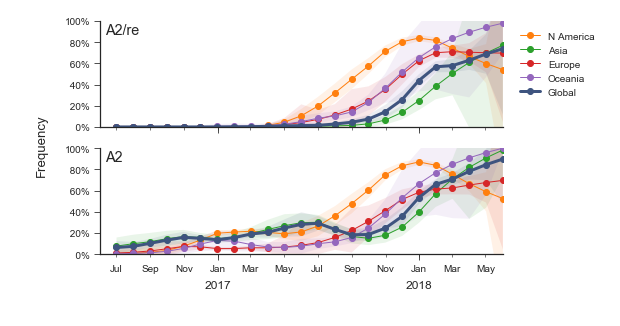

In [5]:
print "Plotting mutation frequencies"
fig, axs = plt.subplots(len(mutations), 1, sharex=True, figsize=(8, len(mutations)*2))
for ci, mutation, ax in zip(range(len(mutations)), mutations, axs):
    for c,region in zip(cols, regions):
        if '%s_%s'%(region, mutation) in freqs:
            tmp_freq = np.array(freqs['%s_%s'%(region, mutation)])
            std_dev = np.sqrt(tmp_freq*(1-tmp_freq)/(smoothed_count_by_region[region]+1))
            ax.plot(pivots[drop:], tmp_freq[drop:], '-o', label = region_label[region], c=c, lw=3 if region=='global' else 1)
            if show_errorbars:
                ax.fill_between(pivots[drop:], (tmp_freq-n_std_dev*std_dev)[drop:], (tmp_freq+n_std_dev*std_dev)[drop:], facecolor=c, linewidth=0, alpha=0.1)
        else:
            print "no data for", mutation, region, "padding with zeros"
            tmp_freq = np.zeros(len(pivots))
            std_dev = np.sqrt(tmp_freq*(1-tmp_freq)/(smoothed_count_by_region[region]+1))
            ax.plot(pivots[drop:], tmp_freq[drop:], '-o', label = region_label[region], c=c, lw=3 if region=='global' else 1)
            if show_errorbars:
                ax.fill_between(pivots[drop:], (tmp_freq-n_std_dev*std_dev)[drop:], (tmp_freq+n_std_dev*std_dev)[drop:], facecolor=c, linewidth=0, alpha=0.1)
    ax.set_xlim([pivots[drop-1], pivots[-1]])
    ax.set_ylim(0,1)
    ax.text(pivots[drop-1]+10, 0.88, (mutation_labels[mutation] if mutation in mutation_labels else mutation), fontsize=fs*1.2)
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
    ax.tick_params(axis='x', which='major', labelsize=fs, pad=20)
    ax.tick_params(axis='x', which='minor', pad=7)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)

fig.autofmt_xdate(bottom=0.25, rotation=0, ha='center')
fax = fig.add_axes( [0., 0., 1, 1] )
fax.set_axis_off()
fax.set_xlim(0, 1)
fax.set_ylim(0, 1)
fax.text(0.02, 0.54, "Frequency", rotation='vertical', horizontalalignment='center', verticalalignment='center', fontsize=fs*1.1)
axs[mut_legend['panel']].legend(loc=mut_legend['loc'], ncol=1, bbox_to_anchor=(1.02, 0.2))
bottom_margin = 0.22 - 0.03*len(mutations)
plt.subplots_adjust(left=0.12, right=0.82, top=0.97, bottom=bottom_margin)
sns.despine()
plt.savefig(output_file_prefix+virus+'_freq_mutations.png', dpi=dpi)

Plotting mutation frequencies by region by region


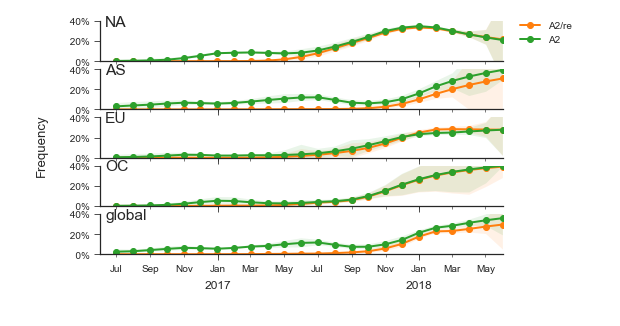

In [6]:
print "Plotting mutation frequencies by region by region"
fig, axs = plt.subplots(len(regions), 1, sharex=True, figsize=(8, len(mutations)*2))
for region,ax in zip(regions, axs):
    for ci,c, mutation in zip(range(len(mutations)),cols, mutations):
        if '%s_%s'%(region, mutation) in freqs:
            tmp_freq = np.array(freqs['%s_%s'%(region, mutation)])
            std_dev = np.sqrt(tmp_freq*(1-tmp_freq)/(smoothed_count_by_region[region]+1))
            ax.plot(pivots[drop:], tmp_freq[drop:], '-o', c=c, lw=2,
                label = (mutation_labels[mutation] if mutation in mutation_labels else mutation))
            if show_errorbars:
                ax.fill_between(pivots[drop:], (tmp_freq-n_std_dev*std_dev)[drop:], (tmp_freq+n_std_dev*std_dev)[drop:], facecolor=c, linewidth=0, alpha=0.1)
        else:
            print "no data for", mutation, region, "padding with zeros"
            tmp_freq = np.zeros(len(pivots))
            std_dev = np.sqrt(tmp_freq*(1-tmp_freq)/(smoothed_count_by_region[region]+1))
            ax.plot(pivots[drop:], tmp_freq[drop:], '-o', label = ("clade %d"%(ci+1) if virus=='h3n2' else mutation), c=c, lw=2)
            if show_errorbars:
                ax.fill_between(pivots[drop:], (tmp_freq-n_std_dev*std_dev)[drop:], (tmp_freq+n_std_dev*std_dev)[drop:], facecolor=c, linewidth=0, alpha=0.1)

    ax.set_xlim([pivots[drop-1], pivots[-1]])
    ax.set_ylim(0,1)
    ax.text(pivots[drop-1]+10, 0.88, region, fontsize=fs*1.3)
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
    ax.tick_params(axis='x', which='major', labelsize=fs, pad=20)
    ax.tick_params(axis='x', which='minor', pad=7)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)

fig.autofmt_xdate(bottom=0.25, rotation=0, ha='center')
fax = fig.add_axes( [0., 0., 1, 1] )
fax.set_axis_off()
fax.set_xlim(0, 1)
fax.set_ylim(0, 1)
fax.text(0.02, 0.54, "Frequency", rotation='vertical', horizontalalignment='center', verticalalignment='center', fontsize=fs*1.1)
axs[mut_legend['panel']].legend(loc=mut_legend['loc'], ncol=1, bbox_to_anchor=(1.02, 0.2))
bottom_margin = 0.22 - 0.03*len(mutations)
plt.subplots_adjust(left=0.12, right=0.82, top=0.97, bottom=bottom_margin)
sns.despine()
plt.savefig(output_file_prefix+virus+'_freq_mutations_by_region.png', dpi=dpi)

In [7]:
ha_input_file_prefix = '../nextstrain/auspice/data/flu_seasonal_h3n2_ha_2y'
na_input_file_prefix = '../nextstrain/auspice/data/flu_seasonal_h3n2_na_2y'
ha_freqs = json.load(open(ha_input_file_prefix+'_frequencies.json'))
na_freqs = json.load(open(na_input_file_prefix+'_frequencies.json'))

ha_a2_re = np.array(ha_freqs['global_A2/re'])
ha_a2_no_re = np.array(ha_freqs['global_A2']) - np.array(ha_freqs['global_A2/re'])
na_a2_re = np.array(na_freqs['global_NA:386S'])
na_a2_no_re = np.array(na_freqs['global_nuc:1436C']) - na_a2_re
#na_a2_no_re = np.array([0]*25)

In [8]:
[ clade is None for clade in re_clades]

NameError: name 're_clades' is not defined

In [ ]:
# From [4]
re_clades = [ha_a2_re, ha_a2_no_re, na_a2_re, na_a2_no_re]
clade_labels = ['HA:A2/re', 'HA:A2', 'NA:A2/re', 'NA:A2']
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, len(clades)*2))
for clade_i, ax in zip(range(len(re_clades)), axs):
    tmp_freq = re_clades[clade_i]
    if tmp_freq is not None:
        std_dev = np.sqrt(tmp_freq*(1-tmp_freq)/(smoothed_count_by_region[r1]+1))
        ax.plot(pivots, tmp_freq,'-o', label = region_label[r1], c='#000000', lw=3 if region=='global' else 1)
        if show_errorbars:
            ax.fill_between(pivots, tmp_freq-n_std_dev*std_dev, tmp_freq+n_std_dev*std_dev, facecolor='#000000', linewidth=0, alpha=0.1)
        ax.set_xlim([pivots[0], pivots[-1]])
        ax.set_ylim(0,1.0)
        ax.text(pivots[0]+5, 0.88, clade_labels[clade_i])
        ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
        ax.tick_params(axis='x', which='major', labelsize=fs, pad=20)
        ax.tick_params(axis='x', which='minor', pad=7)
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.xaxis.set_minor_locator(months)
        ax.xaxis.set_minor_formatter(monthsFmt)
    fig.autofmt_xdate(bottom=0.25, rotation=0, ha='center')
    fax = fig.add_axes( [0., 0., 1, 1] )
    fax.set_axis_off()
    fax.set_xlim(0, 1)
    fax.set_ylim(0, 1)
    fax.text(0.02, 0.54, "Frequency", rotation='vertical', horizontalalignment='center', verticalalignment='center')
    axs[clade_legend['panel']].legend(loc=clade_legend['loc'], ncol=1, bbox_to_anchor=(1.02, 0.2))
    bottom_margin = 0.22 - 0.03*len(re_clades)
    plt.subplots_adjust(left=0.12, right=0.82, top=0.97, bottom=bottom_margin)
    sns.despine()
    plt.savefig(output_file_prefix+virus+'_freq_clades_A2RE.png', dpi=dpi)

In [ ]:
plt.gcf().clear()
t = ha_a2_re - na_a2_re
t